<a href="https://colab.research.google.com/github/LokiAndere/MIARFID-VPC-2019-20/blob/master/VGG_family.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import keras.backend as BCKN
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D
from keras.layers import ReLU, Softmax
from keras.layers import BatchNormalization as BN
from keras.utils.vis_utils import plot_model

**Alex Net**

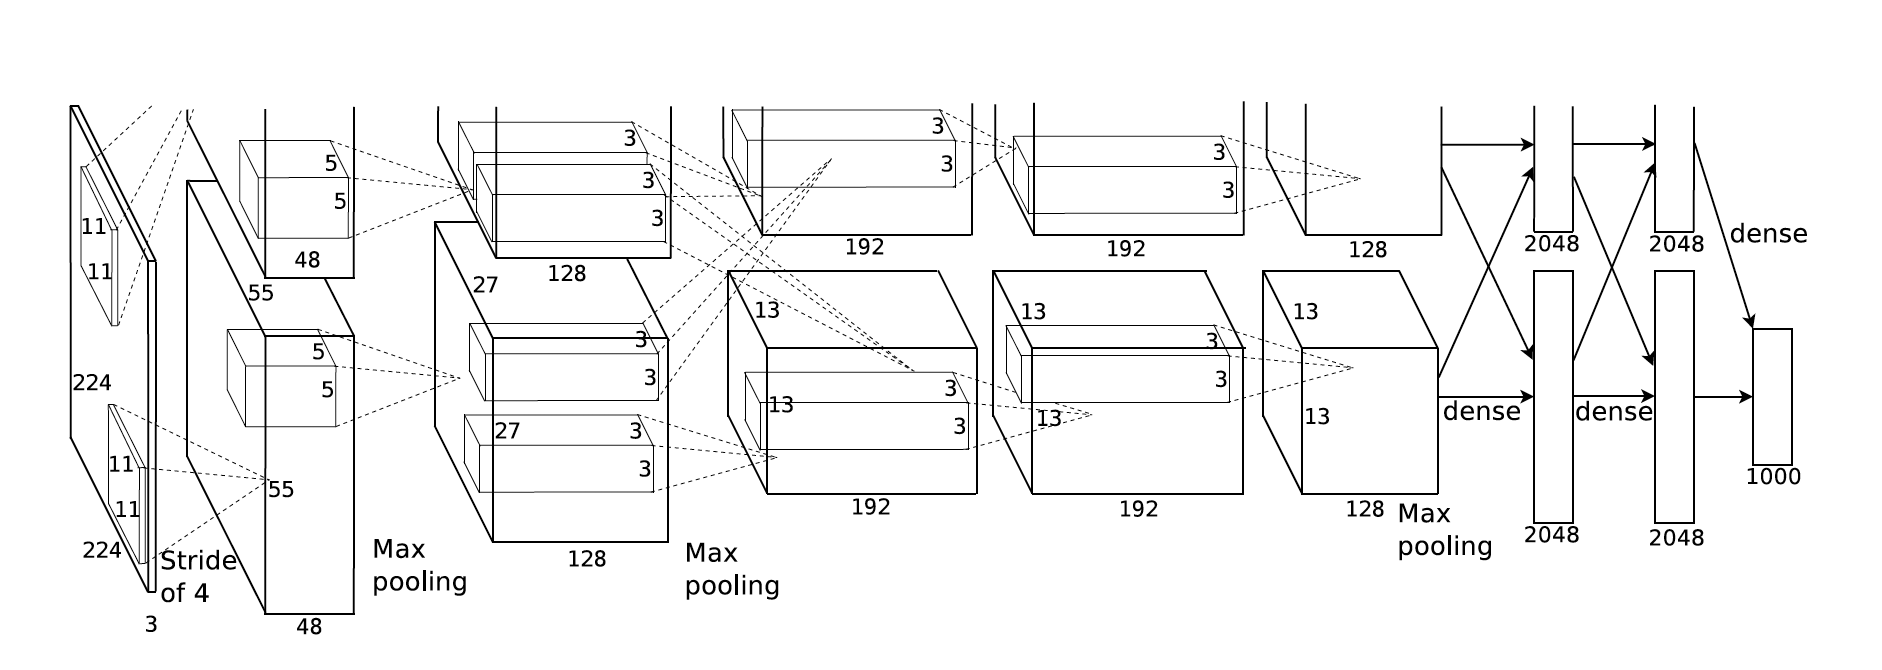

In [0]:
#it is from the same family as vgg but older
#as we can see on image the first convolution it performs is actoally 11x11
#so we consider this step as one that looses a lot of important information
#and the number of layers is low
#we consider it as a part of vgg topology which we shall consider next

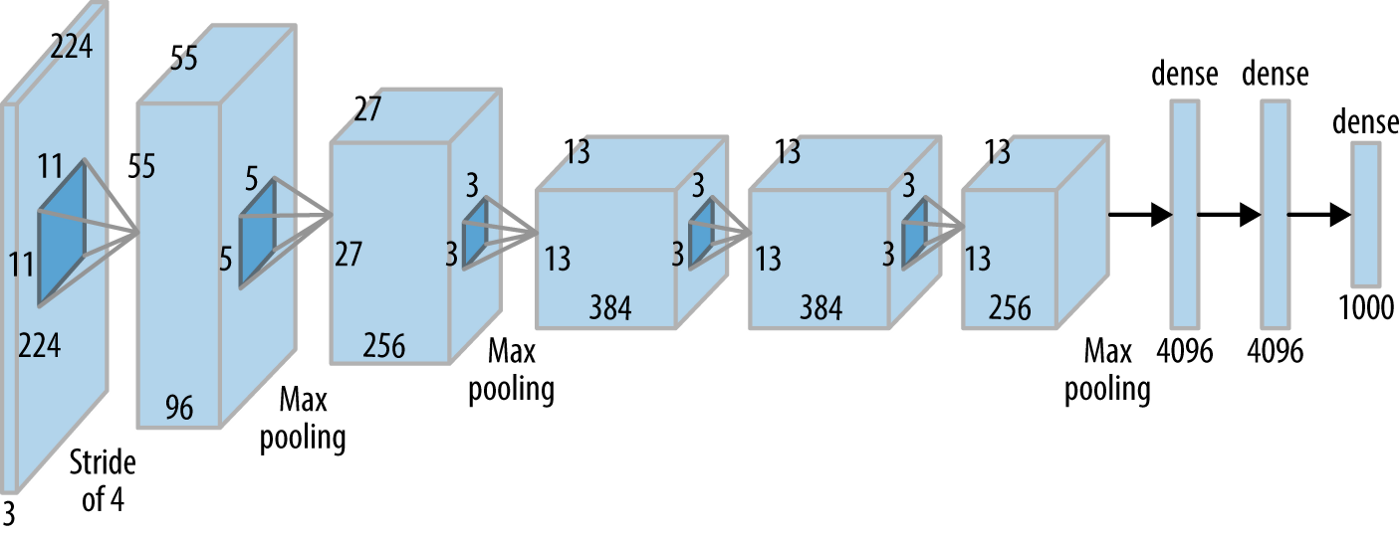

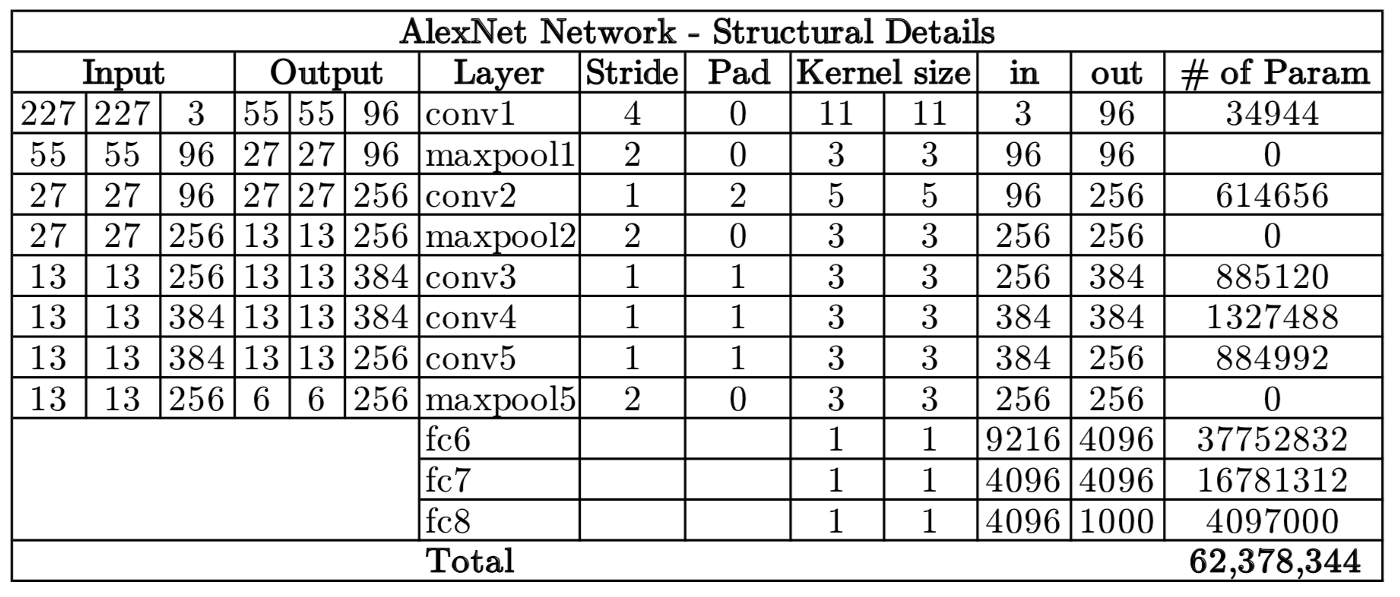

In [0]:
def ANet(shape, num_classes):

  def CR(model, features, kernal=1, stride=1, padd='same'):
    model = Conv2D(features, kernel_size=kernal, strides=stride, padding=padd) (model)
    model = ReLU() (model)
    return model

  def CRBNM(model, features, kernal=1, stride=1, padd='same'):
    model = CR(model, features, kernal, stride, padd)
    model = BN() (model)
    model = MaxPooling2D(3, strides=2)(model)
    return model

  first = Input(shape)
  model = CRBNM(first, 96, 11, 4)
  model = CRBNM(model, 256, 5)
  model = CR(model, 384, 3)
  model = CR(model, 384, 3)
  model = CRBNM(model, 256, 3)
  
  #tail
  model = Flatten()(model)
  model = Dense(4096)(model)
  model = ReLU() (model)
  model = Dense(4096)(model)
  model = ReLU() (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  final = Model(first, last)
  
  return final

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 56, 56, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 27, 27, 256)       0   

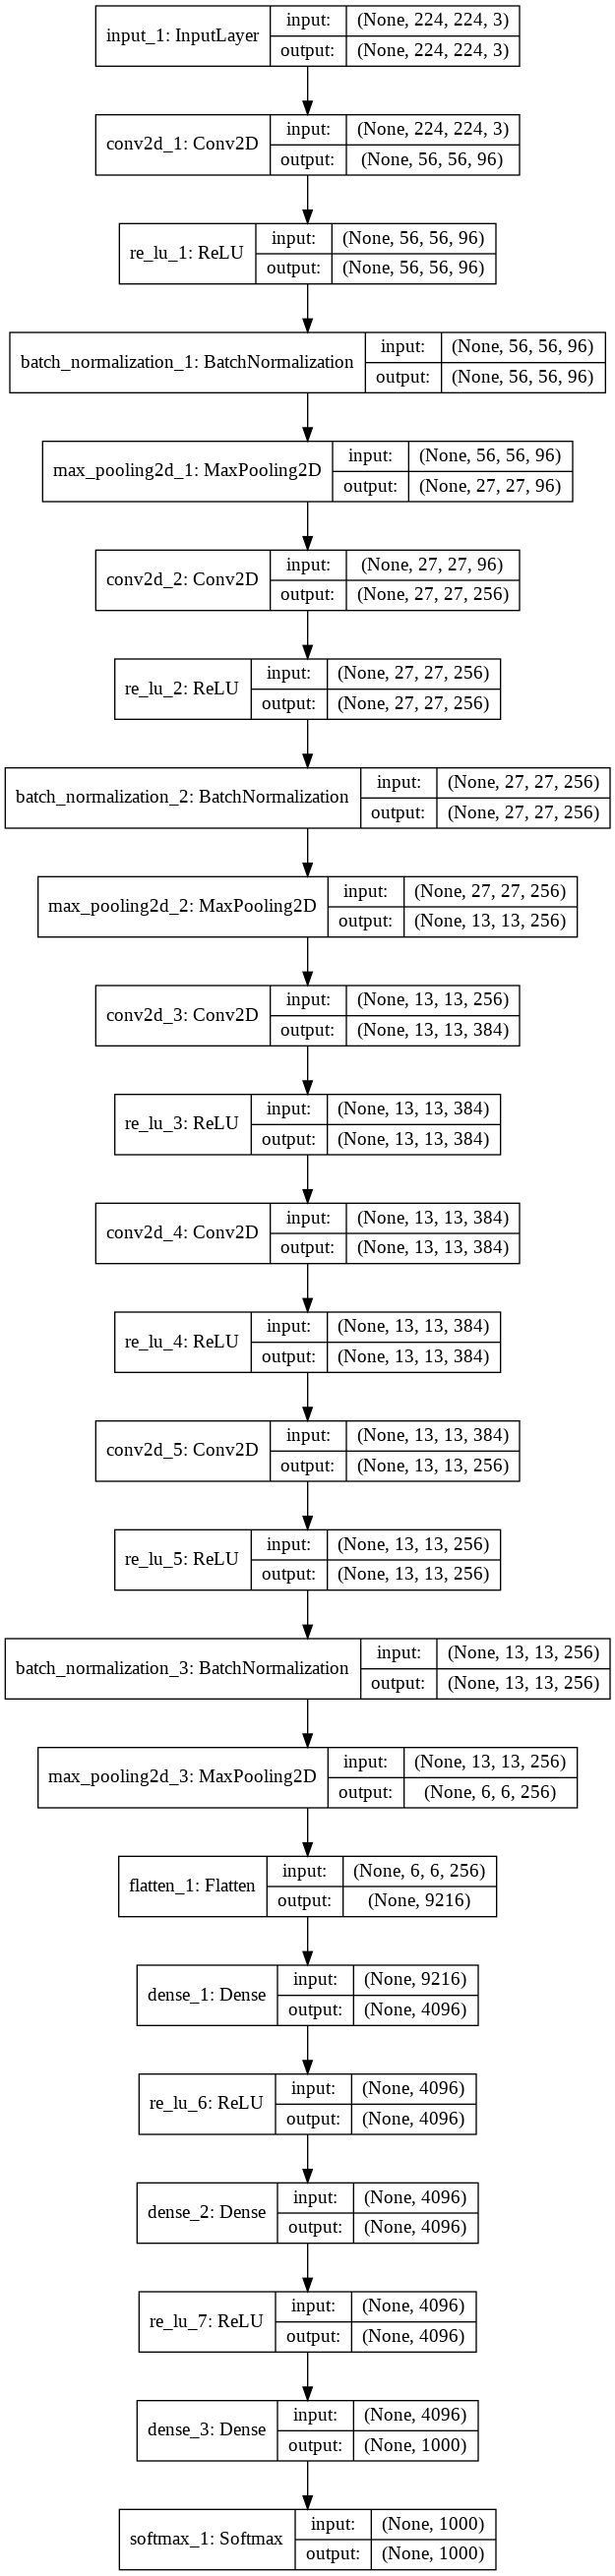

In [0]:
shape = (224, 224, 3)
num_classes = 1000
BCKN.clear_session()
model = ANet(shape, num_classes)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**VGG**

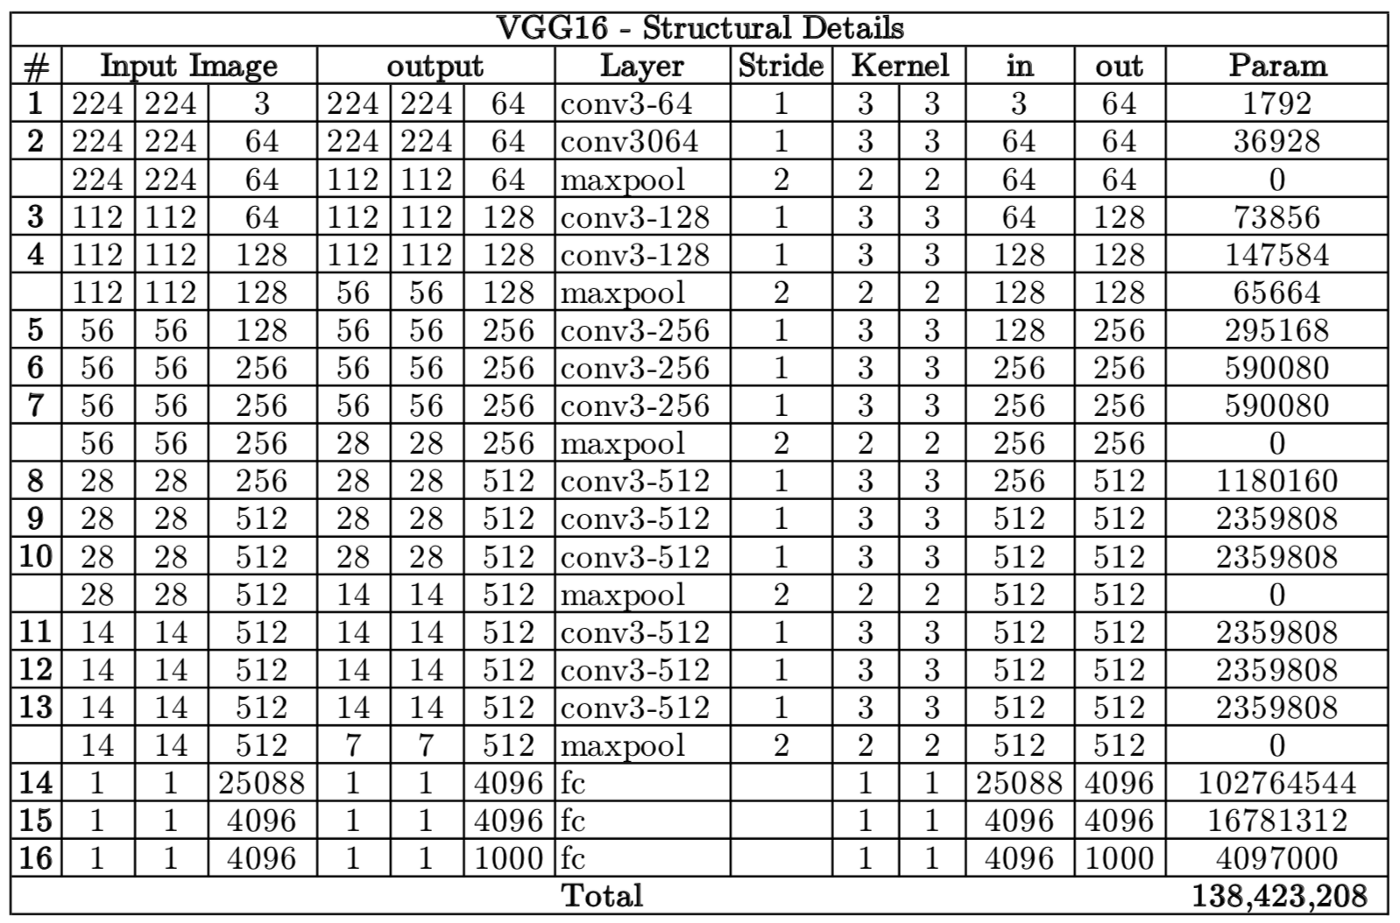

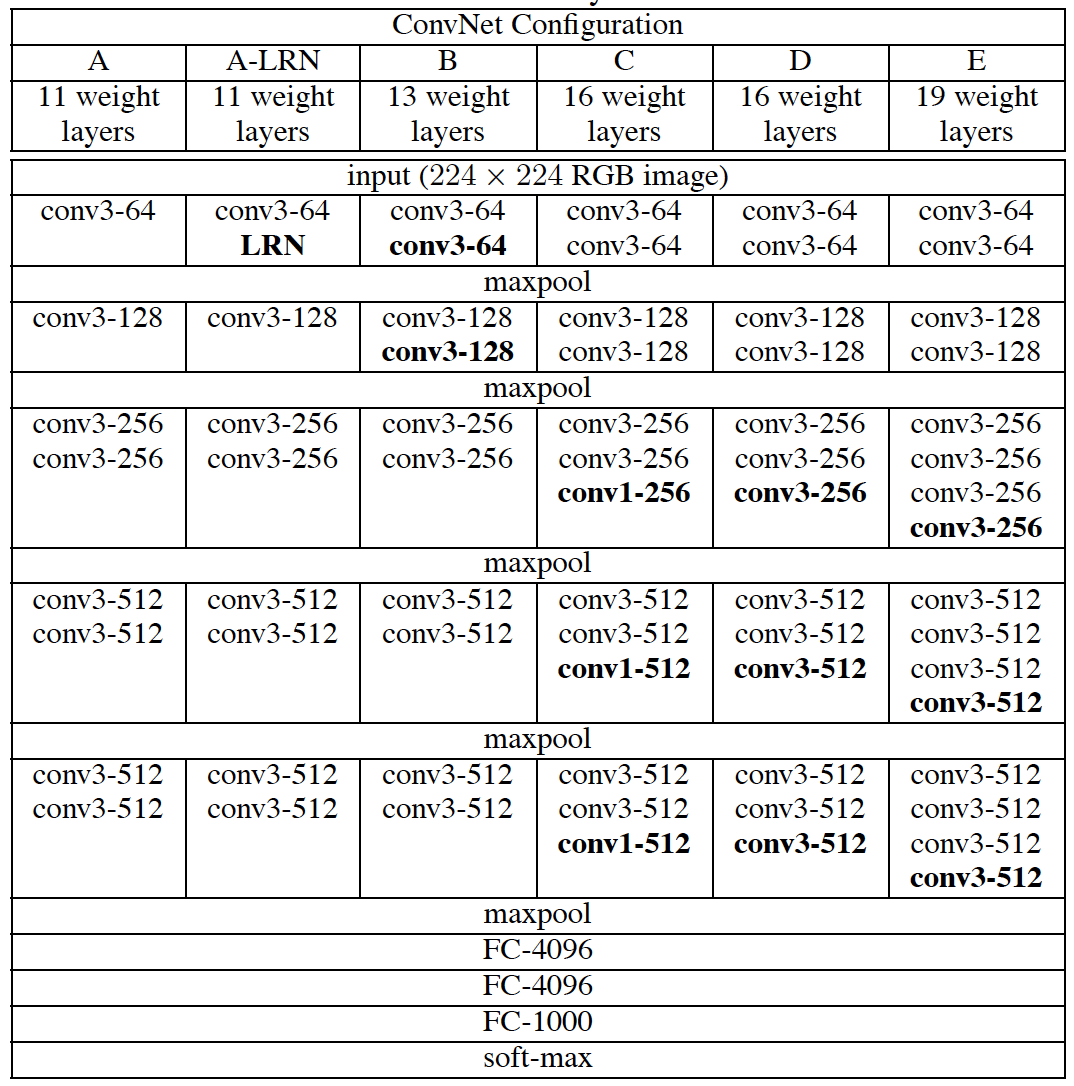

In [0]:
def VGG (shape, num_classes, arch_list = (1, 1, 2, 2, 2)):

  #the A-LNR and C options are not introduced but easiely can be implemented
  #both aproaches from this family (alex and vgg) use for regularization LNR
  #LRN stands for local response normalization - some technic from time far away
  #it involves riding a microra... or it is microraptor who is riding us...
  #long story short nowardays we are using batch normalization
  #and in any case in this example it will not come in hand

  first = Input(shape)

  #convolution relu block
  def CR (model, filters):
    model = Conv2D(filters, 3, padding='same') (model)
    model = ReLU() (model)
    return model

  sizes = 64, 128, 256, 512, 512
  #vgg full block
  #full stands for the fact that we did not divide for smaller five blocks
  def VGGFB (model):
    for s, a in zip(sizes, arch_list):
      for _ in range(a):
        model = CR(model, s)
      model = MaxPooling2D(2, strides=2, padding='same') (model)
    return model
  
  #main constructor
  model = VGGFB (first)

  #as it was said in the paper adding normalization
  #does not give any sizable advantage
  #so we basically did not
  #we did not add any normalization at all
  #even though adding normalization requires not that much code editing

  #tail
  model = Flatten()(model)
  model = Dense(4096)(model)
  model = ReLU() (model)
  model = Dense(4096)(model)
  model = ReLU() (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  final = Model(first, last)

  return final

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     7385

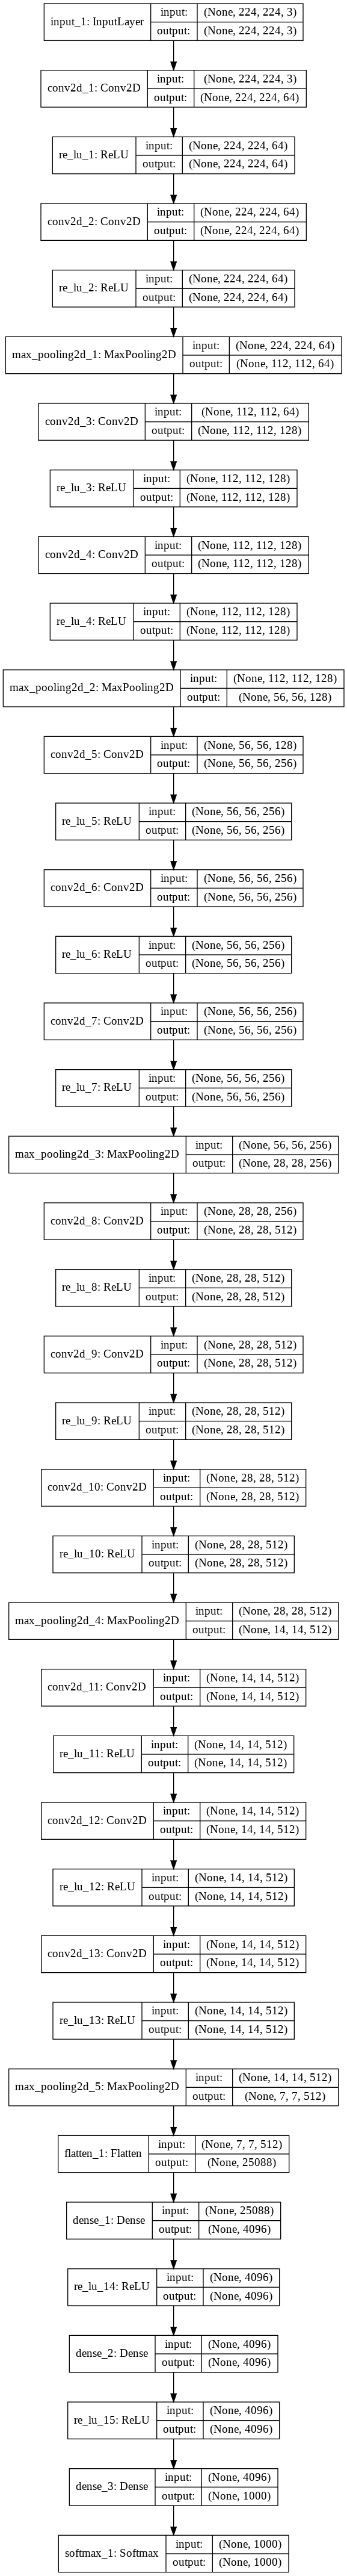

In [0]:
shape = (224, 224, 3)
num_classes = 1000
architecture = (2, 2, 3, 3, 3)
BCKN.clear_session()
model = VGG(shape, num_classes, architecture)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:

#lets do some experiments
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


batch_size = 100
num_classes = 10
epochs = 150


#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


## DEFINE A DATA AUGMENTATION GENERATOR

datagen = ImageDataGenerator(
  featurewise_center=True,
  featurewise_std_normalization=True,
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=40,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)


###########################################################
# Now this is necessary due to the feature normalization: #
datagen.fit(x_train)

testdatagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

testdatagen.fit(x_train)

BCKN.clear_session()
model = VGG(x_train.shape[1:], 10, (1,1,2,2,2))
model.summary()

## OPTIM AND COMPILE
opt = SGD(lr=0.1, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 50:
        return .1
    elif epoch < 100:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)


## TRAINING with DA and LRA
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=testdatagen.flow(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxP

In [0]:
#we've got 0.8716 but forgot to save the result
#so please search in table above
#but it was asked to achieve 70%

In [0]:
import keras
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN

import os
import tensorflow as tf

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 14s 0us/step


In [9]:
# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))

(50000, 32, 32, 3)
(50000, 1)
[5000]
[5000]
(10000, 32, 32, 3)
(10000, 1)
[1000]
[1000]


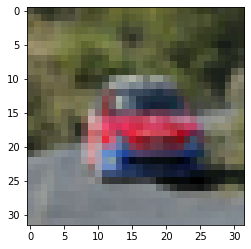

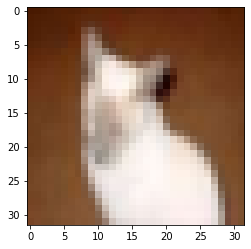

In [10]:
plt.imshow(x_train[6969,:,:,: ] )
plt.show()
plt.imshow(x_train[1487,:,:,: ] )
plt.show()

In [11]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [0]:
BCKN.clear_session()
model = VGG(x_train.shape[1:], 10, (2,2,3,3,3))

In [0]:
## OPTIM AND COMPILE
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [15]:
batch_size = 100
num_classes = 2
epochs = 50

# TRAINING
history = model.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_test, y_test),
         callbacks = [early_stop]
         )#shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 50s 994us/step - loss: 2.1894 - accuracy: 0.1630 - val_loss: 1.9093 - val_accuracy: 0.2649
Epoch 2/50
50000/50000 [==============================] - 42s 846us/step - loss: 1.7502 - accuracy: 0.3247 - val_loss: 1.5250 - val_accuracy: 0.4148
Epoch 3/50
50000/50000 [==============================] - 42s 846us/step - loss: 1.4326 - accuracy: 0.4566 - val_loss: 1.3198 - val_accuracy: 0.5127
Epoch 4/50
50000/50000 [==============================] - 42s 847us/step - loss: 1.1584 - accuracy: 0.5788 - val_loss: 1.0817 - val_accuracy: 0.6097
Epoch 5/50
50000/50000 [==============================] - 42s 846us/step - loss: 0.9456 - accuracy: 0.6610 - val_loss: 0.9711 - val_accuracy: 0.6612
Epoch 6/50
50000/50000 [==============================] - 42s 845us/step - loss: 0.7756 - accuracy: 0.7262 - val_loss: 0.8345 - val_accuracy: 0.7062
Epoch 7/50
50000/50000 [==============================] 

In [16]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 4s 421us/step
Test loss: 1.2525282333612442
Test accuracy: 0.8192999958992004


In [0]:
#again we could not print the best result. 0.8277